<a href="https://colab.research.google.com/github/sayoneenandi/waiting_in_aNe/blob/main/All3_Models_Copy_of_System_Dynamics_Hospital.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# rolling average ed attendance

In [614]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math
!pip install mplcursors
import mplcursors

class RollingAverageEDattendance:
    def __init__(self, historical_emergency_attendance, baseline_date):
        self.historical_emergency_attendance = historical_emergency_attendance
        self.baseline_date = baseline_date

        self.average_emergecny_attendance_attendances = None
        self.rolling_avg_period = len(historical_emergency_attendance)

        self.data_delayed = [historical_emergency_attendance['IC-02 Historical Emergency Attendances'].iloc[0] for _ in range(self.rolling_avg_period)]
        self.historical_standard_deviation = np.std(historical_emergency_attendance['IC-02 Historical Emergency Attendances'])

    def delay(self, new_value):
        self.data_delayed.pop(0)
        self.data_delayed.append(new_value)
        return self.data_delayed[0]

    def calculate_delay_fact(self, running_time):
        if running_time < self.baseline_date:
            return self.historical_emergency_attendance.loc[running_time]['IC-02 Historical Emergency Attendances']
        else:
            return self.delay(self.historical_emergency_attendance.loc[running_time]['IC-02 Historical Emergency Attendances'])

    def average_emergecny_attendance(self, running_time, weekly_data):
        if running_time < self.baseline_date:
            return weekly_data
        else:
            rolling_avg_emergency = self.cumulative / self.rolling_avg_period
            std_dev_emergency = self.calculate_std_dev(running_time)
            return np.random.normal(rolling_avg_emergency, std_dev_emergency)

    def rolling_average_ed_attendance_avg_Emg_attendances(self, running_time):
        weekly_data = self.historical_emergency_attendance.loc[running_time]['IC-02 Historical Emergency Attendances']
        self.rolling_avg_period = len(self.historical_emergency_attendance.loc[:running_time])
        rolling_avg_emergency = self.cumulative / self.rolling_avg_period

        self.average_emergecny_attendance_attendances = self.average_emergecny_attendance(running_time, weekly_data)
        return self.average_emergecny_attendance_attendances

    def calculate_std_dev(self, running_time):
        recent_attendance = self.historical_emergency_attendance['IC-02 Historical Emergency Attendances'][-self.rolling_avg_period:]
        return np.std(recent_attendance)

    def calculate_weekly_variation(self, date, weekly_data):
        if date < self.baseline_date:
            return abs(weekly_data - self.cumulative / self.rolling_avg_period)
        else:
            return 0

    def run_cumulative_sim(self, start_time, end_time, dt_denominator):
        dates = DynamicModel.time(dt_denominator, start_time, end_time)
        forecast = []
        rolling_avg = []
        std_dev = []
        self.cumulative = 0
        self.deviation = 0

        for date in dates:
            rolling_avg_emergency = self.rolling_average_ed_attendance_avg_Emg_attendances(date)
            weekly_data_cumulative_inflow = rolling_avg_emergency
            weekly_variation_deviation_inflow = self.calculate_weekly_variation(date, rolling_avg_emergency)

            dt = 1  # Assuming time step of 1 week
            self.cumulative = self.cumulative + dt * (weekly_data_cumulative_inflow - self.cumulative / self.rolling_avg_period)
            self.deviation = self.deviation + dt * weekly_variation_deviation_inflow

            std_dev_emergency = self.calculate_std_dev(date)
            forecast.append(rolling_avg_emergency)
            rolling_avg.append(rolling_avg_emergency)
            std_dev.append(std_dev_emergency)

        return forecast, rolling_avg, std_dev



# Rolling Average Ratio Admission to Attendance

In [615]:
class Rolling_Average_Admission_To_Attendance_Ratio:
    def __init__(self, historical_ratio, baseline_date):
        self.historical_ratio = historical_ratio
        self.baseline_date = baseline_date

        # Global_parameter_initialisation
        global rolling_avg_period_ratio_attendances
        global weeks_in_year
        global reduction_non_elective_admission_to_attendance_rate
        global time_in_weeks_to_reach_reduction

        self.rolling_avg_period_ratio_attendances = rolling_avg_period_ratio_attendances
        self.weeks_in_year = weeks_in_year
        self.reduction_non_elective_admission_to_attendance_rate = reduction_non_elective_admission_to_attendance_rate
        self.time_in_weeks_to_reach_reduction = time_in_weeks_to_reach_reduction
        self.data_delayed = [historical_ratio['Ratio Admission to Attendance'].iloc[0] for _ in range(self.rolling_avg_period_ratio_attendances)]
        self.cumulative = 0

    # Rest of the class remains the same

    def delay(self, new_value):
        self.data_delayed.pop(0)
        self.data_delayed.append(new_value)
        return self.data_delayed[0]

    def timestamp_to_week_num(self, timestamp):
        return int((timestamp - self.baseline_date).days / 7)

    def weekly_los(self, week_num):
        try:
            return self.historical_ratio.set_index('Time').loc[week_num]['Ratio Admission to Attendance']
        except KeyError:
            return 0

    def outofdatedata(self, week_num):
        try:
            if week_num < self.timestamp_to_week_num(self.baseline_date):
                return self.historical_ratio.set_index('Time').loc[week_num]['Ratio Admission to Attendance']
            else:
                return self.delay(self.historical_ratio.set_index('Time').loc[week_num]['Ratio Admission to Attendance'])
        except KeyError:
            return 0
    def update(self, new_data_point):
        """
        Append new data to historical_ratio.
        :param new_data_point: DataFrame row containing new data.
        """
        self.historical_ratio = self.historical_ratio.append(new_data_point, ignore_index=True)

    def run_cumulative_sim(self, start_time, end_time, dt):
        dates = pd.date_range(start=start_time, end=end_time, freq="W").tolist()  # Weekly frequency
        ratios = []

        for date in dates:
            week_num = self.timestamp_to_week_num(date)
            los = self.weekly_los(week_num)
            outdated = self.outofdatedata(week_num)
            self.cumulative += dt * (los - outdated)

            ramp_value = self.reduction_non_elective_admission_to_attendance_rate / (100 * self.weeks_in_year)
            if date >= self.baseline_date and date <= self.baseline_date + timedelta(weeks=self.time_in_weeks_to_reach_reduction):
                ramp_factor = ramp_value
            else:
                ramp_factor = 0

            ratio = self.cumulative / self.rolling_avg_period_ratio_attendances * (1 - ramp_factor)
            ratios.append(ratio)

        return ratios


# Rolling Average Los Non Elective

In [616]:
from collections import deque

class RollingAverageLosNonElective:
    def __init__(self, historical_los_non_elective, rolling_avg_period_los_non_elective, baseline_date, sim_times, non_elective_date_add, date_model_start):
        self.historical_los_non_elective = historical_los_non_elective
        self.rolling_avg_period_los_non_elective = rolling_avg_period_los_non_elective
        self.baseline_date = baseline_date
        self.running_time = baseline_date
        self.cumulative = 0
        self.delayed_data = deque([self.calculate_init_delayed_data()] * self.rolling_avg_period_los_non_elective,
                                  maxlen=self.rolling_avg_period_los_non_elective)
        self.weekly_variation = 0
        self.std_dev = 0
        self.reduction_per_week = 0
        self.calculated_non_elective_los = 0
        self.deviation = 0
        self.sim_times = sim_times
        self.non_elective_date_add = non_elective_date_add
        self.date_model_start = date_model_start
        self.std_dev = 0
    def RAMP(self, final_value, start_time, end_time):
        """Computes the ramped value based on the current running_time"""
        current_week = self.datetime_to_week_number(self.running_time, self.baseline_date)
        if current_week < start_time:
            return 0
        elif start_time <= current_week < end_time:
            return final_value * (current_week - start_time) / (end_time - start_time)
        else:
            return final_value
    def calculate_reduction_per_week(self):
        final_value = 2.5
        time_to_reduce = 52
        start_time = (self.non_elective_date_add - self.date_model_start).days / 7 * 52
        end_time = start_time + time_to_reduce
        return self.RAMP(final_value, start_time, end_time)
    def calculate_std_dev(self, running_time):
        """Calculate the std_dev based on the running_time and baseline_date"""
        if running_time < self.baseline_date:
            return self.deviation / running_time
        else:
            return self.deviation / self.baseline_date
    def calculate_init_cumulative(self):
        return self.historical_los_non_elective['IC-09 Historical LoS Non Elective'].iloc[0]

    def calculate_init_delayed_data(self):
        return self.historical_los_non_elective['IC-09 Historical LoS Non Elective'].iloc[0]
    def datetime_to_week_number(self, current_datetime, baseline_date):
        delta = current_datetime - baseline_date
        return delta.days // 7


    def outdated_data(self, week_num, weekly_los):
        calculated_date = self.baseline_date + timedelta(weeks=week_num)
        if calculated_date < self.baseline_date:
            return self.calculate_init_delayed_data()
        else:
            self.delayed_data.append(weekly_los)
            return self.delayed_data[0]

    def calculate_weekly_variation(self, weekly_los, outdated_data):
        if self.running_time < self.baseline_date:
            return abs(weekly_los - self.cumulative / self.rolling_avg_period_los_non_elective)
        else:
            return abs(weekly_los - outdated_data)

    def calculate_non_elective_los(self, week_num):

        if self.running_time < self.baseline_date:
            max_value = max(self.historical_los_non_elective['IC-09 Historical LoS Non Elective'])
            print(f"Max value from historical data: {max_value}")
            return max_value
        else:
            calculated_value = max(self.rolling_avg - self.reduction_per_week * self.std_dev, 1)
            print(f"Calculated value: {calculated_value}")
            return calculated_value

    def rolling_avg_los_nonelective_averageLOS(self):
        result = self.cumulative / self.rolling_avg_period_los_non_elective
        print(f"Rolling average LoS: {result}")
        return result

    def non_elective_los(self):
        mean = self.rolling_avg_los_nonelective_averageLOS()
        stddev = 0.25
        normal_value = np.random.normal(mean, stddev)
        print(f"Generated normal value: {normal_value}")
        return normal_value

    def non_elective_los_in_weeks(self, running_time, IC_09_Historical_LoS_Non_Elective):
        Days_in_a_week = 7
        if running_time < self.baseline_date:
            result = IC_09_Historical_LoS_Non_Elective / Days_in_a_week
            print(f"Non-elective LoS in weeks (historical): {result}")
            return result
        else:
            result = self.non_elective_los() / Days_in_a_week
            print(f"Non-elective LoS in weeks (calculated): {result}")
            return result
    def run(self, running_time):

        debug_values = []

        for runtime in self.sim_times:
            self.running_time = runtime
            week_num = self.datetime_to_week_number(runtime, self.baseline_date)

            debug_values.append((runtime, week_num))


            try:
                weekly_los = self.historical_los_non_elective['IC-09 Historical LoS Non Elective'].loc[week_num]
            except KeyError:

                weekly_los = self.historical_los_non_elective['IC-09 Historical LoS Non Elective'].iloc[-1]


            outdated_data = self.outdated_data(week_num, weekly_los)


            self.cumulative += (weekly_los - outdated_data) * (1 / len(self.sim_times))


            self.weekly_variation = self.calculate_weekly_variation(weekly_los, outdated_data)


            self.deviation += self.weekly_variation
            self.rolling_avg = self.rolling_avg_los_nonelective_averageLOS()
            self.reduction_per_week = self.calculate_reduction_per_week()

            self.rolling_avg = self.cumulative / self.rolling_avg_period_los_non_elective

            self.calculated_non_elective_los = self.calculate_non_elective_los(week_num)

        return debug_values


# System Dynamic Model

In [617]:
class DynamicModel:
    @staticmethod
    def time(dt_denominator, start_time, end_date_for_simulation):
        dt = 1.0 / dt_denominator
        time_increment = timedelta(weeks=int(13))  # Quarterly means every 13 weeks
        num_weeks = (end_date_for_simulation - start_time).days // 7
        end_time = start_time + timedelta(weeks=int(num_weeks // dt_denominator))
        return pd.date_range(start=start_time, end=end_time, freq=time_increment).tolist()


    def __init__(self, annual_population_growth_rate, rolling_avg_los_non_elective_instance, A_and_E_Attendances=0, historical_emergency_attendance=[],
             rolling_avg_ratio=None, start_time_of_simulation=None,
             end_date_for_simulation=None, additional_beds=0,
             adding_date_in_weeks=0, time_to_add_beds_in_weeks=52,
             date_model_start=None, RAMP_slope=0):
        self.annual_population_growth_rate = annual_population_growth_rate
        self.A_and_E_Attendances = A_and_E_Attendances
        self.historical_emergency_attendance = historical_emergency_attendance
        self.rolling_avg_ratio = rolling_avg_ratio
        self.start_time_of_simulation = start_time_of_simulation if start_time_of_simulation is not None else datetime.now()
        self.end_date_for_simulation = end_date_for_simulation
        self.running_time = None
        self.dt =dt
        self.annual_population_growth_rate = annual_population_growth_rate
        self.per_week=1
        self.dt_denominator=dt_denominator
        self.additional_beds=0
        self.time_to_add_beds_in_weeks=52
        self.date_add = end_date_for_simulation
        self.date_model_start = date_model_start
        self.adding_date_in_weeks = (self.date_add - self.date_model_start).days / 7 * weeks_in_a_year
        self.patients_per_bed = 1
        self.initial_beds_occupied_non_elective = 250
        self.beds_available_values = []
        self.historical_forecast_attendances = []
        self.patients_needing_admission = []
        self.non_elective_times = []
        self.needing_admission_values = []
        self.waiting_admission_values = []
        self.beds_effectively_used = (operational_days / days_in_a_year) * days_in_a_week
        #self.non_elective_los = non_elective_los
        self.a_e_admitted_ward_values = []
        self.non_elective_los_in_weeks = 0.779
        self.proportion_beds_non_elective = None
        self.rolling_avg_los_non_elective_instance = rolling_avg_los_non_elective_instance
        # Non elective waiting admission stock initialization
        self.Non_elective_waiting_admission = 0
        self.beds_available_for_non_electives = 708
        # Create rolling_avg_forecast internally
        self.rolling_avg_forecast = RollingAverageEDattendance(self.historical_emergency_attendance, self.start_time_of_simulation)
    def get_admission_to_attendance_ratio(self):
        # Get last historical ratio
        last_ratio = self.rolling_avg_ratio.historical_ratio['Ratio Admission to Attendance'].iloc[-1]


        max_historical_timestamp = pd.Timestamp(self.rolling_avg_ratio.historical_ratio.iloc[-1]['Time'])

        if self.running_time > max_historical_timestamp:
            # Use last ratio if past historical data
            return last_ratio

        # Existing code to calculate ratio
        ratios = self.rolling_avg_ratio.run_cumulative_sim(start_time_of_simulation, end_date_for_simulation, dt)

        running_time_index = self.rolling_avg_ratio.time_values.index(self.running_time)
        ratio = ratios[running_time_index]

        if ratio == 0:
            ratio = 0.000001

        return ratio

    def calculate_PatientsNadmission(self, forecast_attendance):
        admission_to_attendance_ratio = self.get_admission_to_attendance_ratio()

        delay_days = avg_time_in_A_and_E_hours / (hours_in_a_day * days_in_a_week)
        patients_needing_admission = forecast_attendance * admission_to_attendance_ratio * delay_days


        #print(f"Debug - calculate_PatientsNadmission: Forecast Attendance: {forecast_attendance}, delay Days: {delay_days}")
        #print(f"Debug - Patients Needing Admission: {patients_needing_admission}")

        return patients_needing_admission

    def calculate_AEnoreqAttendance(self, forecast_attendance):
        admission_to_attendance_ratio = self.get_admission_to_attendance_ratio()

        delay_days = avg_time_in_A_and_E_hours / (hours_in_a_day * days_in_a_week)
        patients_not_required_admission = forecast_attendance * (1 - admission_to_attendance_ratio) * delay_days
        #print(f"Debug - calculate_AEnoreqAttendance: Forecast Attendance: {forecast_attendance}, delay Days: {delay_days}")
        #print(f"Debug - Patients Not Required Admission: {patients_not_required_admission}")

        return patients_not_required_admission

    def calculate_AEattendance(self, running_time):
        #print(f"Debug - calculate_AEattendance: Current Time: {running_time}")

        if running_time < self.start_time_of_simulation:
            # Return Rolling_average_ED_attendance instead of last historical value
            return self.rolling_avg_forecast.rolling_average_ed_attendance_avg_Emg_attendances(running_time)

        else:
            max_historical_time = pd.Timestamp(max(self.historical_emergency_attendance["Time"]))  # <--- This line is added

            if running_time <= max_historical_time:  # <--- And this line is modified
                # If still within historical data range, use actual attendance
                index = self.historical_emergency_attendance["Time"].tolist().index(running_time)
                return self.historical_emergency_attendance["IC-02 Historical Emergency Attendances"].iloc[index]

            else:
                # After historical data, forecast using growth rate
                weeks_after_baseline = (running_time - self.start_time_of_simulation).days // 7
                growth_rate_per_week = (1 + self.annual_population_growth_rate) ** (1/weeks_in_year) - 1
                return self.historical_emergency_attendance["IC-02 Historical Emergency Attendances"].iloc[-1] * (1 + growth_rate_per_week) ** weeks_after_baseline

    def waiting_in_a_n_e(self):
        #print(f"Debug - waiting_in_a_n_e: Start Time: {self.start_time_of_simulation}")
        #print(f"Debug - waiting_in_a_n_e: End Date: {self.end_date_for_simulation}")
        # Inside waiting_in_a_n_e
        delay_days = avg_time_in_A_and_E_hours / (hours_in_a_day * days_in_a_week)
        self.AEattendance = self.historical_emergency_attendance["IC-02 Historical Emergency Attendances"].tolist()
        self.time_values = DynamicModel.time(4, self.start_time_of_simulation, self.end_date_for_simulation)
        # self.historical_forecast_attendances.append(forecast_attendance)
        all_time_steps = []
        all_net_flow_values = []
        all_inflow_values = []
        all_outflow_values = []
        all_patients_needing_admission_values = []

        for running_time in self.time_values:
            self.running_time = running_time
            #print(f"Debug - waiting_in_a_n_e: Current Time: {running_time}")

            forecast_attendance = self.calculate_AEattendance(running_time)
            # Add inflow calculation here
            inflow = forecast_attendance
            #print(f"Debug - waiting_in_a_n_e: Forecast Attendance: {forecast_attendance}")
            # Get admission ratio
            admission_ratio = self.get_admission_to_attendance_ratio()
            if admission_ratio == 0:
                admission_ratio = 0.00001
            # Calculate patients needing and not needing admission
            # With these lines
            outflow1 = self.calculate_AEnoreqAttendance(inflow)
            outflow2 = self.calculate_PatientsNadmission(inflow)

            patients_needing_admission = outflow2  # Move this line inside the loop

            # Print patients_needing_admission
            #print(f"Debug - waiting_in_a_n_e: Patients Needing Admission: {patients_needing_admission}")

            # patients_not_required_admission = self.calculate_AEnoreqAttendance()
            #print(f"Debug - waiting_in_a_n_e: Patients Not Required Admission: {outflow1}")
            # Calculate net flow
            # Calculate net flow
            # With this line
            net_flow = inflow - outflow1 - outflow2

            # Updated code
            inflow_value = inflow
            outflow_value = outflow1 + outflow2

            # Print patients_needing_admission
            #print(f"Debug - waiting_in_a_n_e: Patients Needing Admission: {patients_needing_admission}")
            all_time_steps.append(running_time)
            all_net_flow_values.append(net_flow)
            all_inflow_values.append(inflow_value)
            all_outflow_values.append(outflow_value)
            all_patients_needing_admission_values.append(patients_needing_admission)
            #print(f"Debug - waiting_in_a_n_e: Patients Needing Admission: {patients_needing_admission}")
            self.historical_forecast_attendances.append(forecast_attendance)
            #print(f"Debug - waiting_in_a_n_e: Current Time: {running_time}, Net Flow: {net_flow}, Inflow: {inflow_value}, Outflow: {outflow_value}, Patients Needing Admission: {patients_needing_admission}")

            self.AEattendance.append(self.AEattendance[-1] + net_flow * dt)  # Append inflow_value to AEattendance
            # Append net_flow to all_net_flow_values
            all_net_flow_values.append(net_flow)

        return all_time_steps, all_net_flow_values, all_inflow_values, all_outflow_values, all_patients_needing_admission_values

     # Modify existing methods to use the new algorithms
    def A_and_E_admitted_to_ward(self):
        times, occupied_beds, inflows, outflows = self.beds_occupied_by_non_electives()
        return min(self.beds_available_for_non_electives, occupied_beds[-1])


        return min(self.beds_available_for_non_electives, patients_ready_for_admission)
    def update_Non_elective_waiting_admission(self, inflow, outflow):
        """
        Update the stock of Non_elective_waiting_admission using the difference between inflow and outflow.
        """
        self.Non_elective_waiting_admission = self.Non_elective_waiting_admission + dt * (inflow - outflow)

    def run_non_elective_simulation(self):
        # Run the simulation over the defined time range
        for running_time in self.time_values:
            self.running_time = running_time

            # Calculate inflow, outflow, update stock
            inflow = self.calculate_PatientsNadmission(self.calculate_AEattendance(running_time))
            discharges, beds_available = self.non_elective_discharges_updated()
            outflow = self.A_and_E_admitted_to_ward()
            self.update_Non_elective_waiting_admission(inflow, outflow)

            # Store the values
            self.non_elective_times.append(running_time)
            self.needing_admission_values.append(inflow)
            self.waiting_admission_values.append(self.Non_elective_waiting_admission)
            self.a_e_admitted_ward_values.append(outflow)
            self.beds_available_values.append(beds_available)

    def get_non_elective_simulation_results_dataframe(self):
        """Return simulation results as a pandas DataFrame."""
        df = pd.DataFrame({
            'Time': self.non_elective_times,
            'Patients Needing Admission': self.needing_admission_values,
            'Non-Elective Waiting Admission Stock': self.waiting_admission_values,
            'A&E Admitted to Ward': self.a_e_admitted_ward_values
        })
        return df
    def ramp(self, slope, start_time, end_time):

        if self.running_time < start_time:
          return 0

        elif self.running_time >= start_time and self.running_time <= end_time:
          return slope * (self.running_time - start_time)

        else:
          return slope * (end_time - start_time)

    def get_non_elective_LoS_in_weeks(self):
        # Fetching the value from the RollingAverageLosNonElective instance
        return self.rolling_avg_los_non_elective_instance.non_elective_los_in_weeks(self.running_time, self.AEattendance)

    def non_elective_discharges_updated(self):
        # Using the updated method to get non_elective_LoS_in_weeks
        if self.get_non_elective_LoS_in_weeks() == 0:
            return 0
        else:
            discharges = self.Non_elective_waiting_admission * self.dt / self.get_non_elective_LoS_in_weeks()
            beds_available = self.beds_available_for_non_electives
            return discharges, beds_available

    def calculate_beds_available_for_non_electives(self, non_elective_discharges):
        per_week = 1  # Assuming per_week is 1, modify if needed

        historical_bed_capacity_value = self.historical_bed_capacity(hospital_bed_capacity_path, self.beds_effectively_used)

        # Use the beds_occupied value directly without calling the method
        beds_occupied = self.beds_occupied

        # Calculate beds_effectively_available_for_non_electives
        beds_effectively_available_for_non_electives = historical_bed_capacity_value - (beds_occupied * per_week)
        if beds_effectively_available_for_non_electives < 0:
            beds_effectively_available_for_non_electives = 0

        beds_available_for_non_electives = (beds_effectively_available_for_non_electives * per_week * 0.9 * self.patients_per_bed + non_elective_discharges) - (beds_occupied * per_week)

        return beds_available_for_non_electives

    def calculate_new_beds(self):

        start = self.start_time_of_simulation + timedelta(weeks=self.adding_date_in_weeks)
        end = start + timedelta(weeks=self.time_to_add_beds_in_weeks)

        return self.ramp(self.additional_beds, start, end)

    def new_beds_operational(self, date_add):

        return self.calculate_new_beds()

    def historical_bed_capacity(self, historical_bed_capacity_path, beds_effectively_used):
      operational_days = 250
      days_in_a_year = 365
      days_in_a_week = 7

      historical_bed_capacity_data = pd.read_excel(historical_bed_capacity_path, sheet_name="Sheet1")
      historical_bed_capacity = historical_bed_capacity_data["IC-03 Historical bed capacity in bed days"]

      return (historical_bed_capacity / beds_effectively_used + self.new_beds_operational(self.running_time)) * operational_days / days_in_a_year * days_in_a_week


    def beds_occupied_by_non_electives(self):
      # Initialize stock, inflow, and outflow
      beds_occupied = self.initial_beds_occupied_non_elective * self.patients_per_bed
      inflow = 0
      outflow = 0

      # Lists to store simulation results
      times = []
      occupied_beds = []
      inflows = []
      outflows = []

      # Get the time values using the time method
      time_values = self.time(self.dt, self.start_time_of_simulation, self.end_date_for_simulation)  # Update 'dt_denominator' to 'dt'

      for running_time in time_values:
          # Calculate inflow and outflow
          non_elective_discharges, beds_available_for_non_electives = self.non_elective_discharges_updated()

          inflow = min(beds_available_for_non_electives, self.Non_elective_waiting_admission * self.per_week)
          outflow = beds_occupied / self.non_elective_los_in_weeks

          # Update stock using system dynamics formula
          beds_occupied = beds_occupied + self.dt * (inflow - outflow)

          # Append results to lists
          times.append(running_time)
          occupied_beds.append(beds_occupied)
          inflows.append(inflow)
          outflows.append(outflow)

      return times, occupied_beds, inflows, outflows


    def update_Non_elective_waiting_admission(self, inflow, outflow):
        self.Non_elective_waiting_admission = self.Non_elective_waiting_admission + self.dt * (inflow - outflow)

    def calculate_beds_occupied_updated(self):
        beds_occupied = []
        results = self.beds_occupied_by_non_electives()

        # Convert tuple to DataFrame
        df = pd.DataFrame({
            'Time': results[0],
            'Beds Occupied': results[1],
            'Inflow': results[2],
            'Outflow': results[3]
        })


        for i in range(len(df)):
            current_value = df.iloc[i]['Beds Occupied']

            non_elective_los_in_weeks = self.fetch_non_elective_los_in_weeks()

            # Calculate beds occupied using the updated value
            beds_occupied_value = (
                    current_value * non_elective_los_in_weeks
                    / self.patients_per_bed * self.per_week
                )

            # Append the value
            beds_occupied.append(beds_occupied_value)

        return beds_occupied
    def proportion_beds_for_non_electives(self, beds_occupied_values, historical_bed_capacity_values, averaging_time):
        smoothed_values = []

        for i in range(len(beds_occupied_values)):
            if i == 0:
                smoothed_value = beds_occupied_values[i]
            else:
                smoothed_value = (beds_occupied_values[i] + averaging_time * smoothed_values[i - 1]) / (1 + averaging_time)

            smoothed_values.append(smoothed_value)

        proportion_values = []

        for i in range(len(smoothed_values)):
            proportion_value = smoothed_values[i] / historical_bed_capacity_values[i]
            proportion_values.append(proportion_value)

        return proportion_values




2nd block

In [618]:


# Global
# Read historical LOS non-elective data from Excel sheet
historical_los_non_elective = pd.read_excel("/content/IC-09 Historical LoS Non Elective.xlsx", sheet_name="Sheet1")
baseline_date = datetime(2028, 1, 1)
operational_days=250
days_in_a_year=365
rolling_avg_period_los_non_elective = 26
patients_per_bed = 1
per_week = 1
weeks_in_year = 52
weeks_in_a_year = 52
sim_time = 676
#non_elective_los_in_weeks = 0.779
#non_elective_los=5.54
dt_denominator =1  # Time step denominator (quarterly)
dt = 1.0 / dt_denominator
#rolling_average_ed_attendance_avg_Emg_attendances = 1700
#annual_population_growth_rate = 0.02
baseline = 208
avg_time_in_A_and_E_hours = 4
hours_in_a_day = 24
days_in_a_week = 7
rolling_avg_period_ratio_attendances = 39
reduction_non_elective_admission_to_attendance_rate=0
time_in_weeks_to_reach_reduction=52
patients_per_bed=1
time_to_add_beds_in_weeks=52
additional_beds=0
hospital_bed_capacity_path = "/content/IC-03 Historical bed capacity in bed days.xlsx"
#admission_to_attendance_ratio = 0.214
start_time_of_simulation = baseline_date + timedelta(weeks=baseline)
end_date_for_simulation = baseline_date + timedelta(weeks=sim_time)
exact_sim_time = int(sim_time * dt_denominator)
non_elective_date_add =end_date_for_simulation
print(f"Start Time for Simulation:{start_time_of_simulation}")
print(f"End Date for Simulation:{ end_date_for_simulation}")

historical_emergency_attendance = pd.read_excel("/content/IC-02 Historical Emergency Attendances.xlsx", sheet_name="Sheet1")
forecast_attendance = historical_emergency_attendance["IC-02 Historical Emergency Attendances"].tolist()

historical_time_values = pd.to_datetime(historical_emergency_attendance["Time"])

historical_ratio=pd.read_excel("/content/IC-02 Historical Ratio.xlsx")

rolling_avg = RollingAverageEDattendance(historical_emergency_attendance, baseline_date)

rolling_avg_ratio = Rolling_Average_Admission_To_Attendance_Ratio(historical_ratio, baseline_date)


admission_to_attendance_ratios = rolling_avg_ratio.run_cumulative_sim(start_time_of_simulation, end_date_for_simulation, dt)
adding_date_in_weeks = (non_elective_date_add - start_time_of_simulation).days // 7 * weeks_in_a_year
# Create an instance of RollingAverageLosNonElective
rolling_avg_los_non_elective_instance = RollingAverageLosNonElective(
    historical_los_non_elective=historical_los_non_elective,  # using the existing variable name
    rolling_avg_period_los_non_elective=rolling_avg_period_los_non_elective,
    baseline_date=baseline_date,
    sim_times=DynamicModel.time(dt_denominator, start_time_of_simulation, end_date_for_simulation),
    non_elective_date_add=non_elective_date_add,
    date_model_start=start_time_of_simulation
)


# Initialize the DynamicModel
SystemDynamic_NHS = DynamicModel(
    historical_emergency_attendance=historical_emergency_attendance,
    rolling_avg_ratio=rolling_avg_ratio,
    rolling_avg_los_non_elective_instance=rolling_avg_los_non_elective_instance,  # passing the created instance
    start_time_of_simulation=start_time_of_simulation,
    end_date_for_simulation=end_date_for_simulation,
    additional_beds=additional_beds,
    adding_date_in_weeks=adding_date_in_weeks,
    time_to_add_beds_in_weeks=time_to_add_beds_in_weeks,
    date_model_start=start_time_of_simulation,annual_population_growth_rate=1.2)
all_time_steps, all_net_flow_values, all_inflow_values, all_outflow_values, all_patients_needing_admission_values = SystemDynamic_NHS.waiting_in_a_n_e()

running_time = start_time_of_simulation
'''
print(f"Start Time for Simulation:"+ start_time_of_simulation)
print(f"End Date for Simulation:"+ end_date_for_simulation)
print(f"Exact Sim Time:"+exact_sim_time)'''
# Access simulation times
#sim_times = SystemDynamic_NHS.running_time
# Define non_elective_date_add
non_elective_date_add = end_date_for_simulation
date_model_start = start_time_of_simulation

# Calculate simulation times
sim_times = DynamicModel.time(dt_denominator, baseline_date, SystemDynamic_NHS.end_date_for_simulation)
# Run the simulation
rolling_avg_los_non_elective_instance.run(baseline_date)

debug_output = rolling_avg_los_non_elective_instance.run(baseline_date)
debug_output





Start Time for Simulation:2031-12-27 00:00:00
End Date for Simulation:2040-12-15 00:00:00
Rolling average LoS: 0.0010054377203742204
Calculated value: 1
Rolling average LoS: 0.002010875440748441
Calculated value: 1
Rolling average LoS: 0.0030163131611226613
Calculated value: 1
Rolling average LoS: 0.004021750881496882
Calculated value: 1
Rolling average LoS: 0.005027188601871103
Calculated value: 1
Rolling average LoS: 0.0060326263222453234
Calculated value: 1
Rolling average LoS: 0.007038064042619544
Calculated value: 1
Rolling average LoS: 0.008043501762993765
Calculated value: 1
Rolling average LoS: 0.009048939483367987
Calculated value: 1
Rolling average LoS: 0.010054377203742205
Calculated value: 1
Rolling average LoS: 0.011059814924116425
Calculated value: 1
Rolling average LoS: 0.012065252644490645
Calculated value: 1
Rolling average LoS: 0.013070690364864865
Calculated value: 1
Rolling average LoS: 0.014076128085239085
Calculated value: 1
Rolling average LoS: 0.0150815658056133

[(Timestamp('2031-12-27 00:00:00', freq='91D'), 208),
 (Timestamp('2032-03-27 00:00:00', freq='91D'), 221),
 (Timestamp('2032-06-26 00:00:00', freq='91D'), 234),
 (Timestamp('2032-09-25 00:00:00', freq='91D'), 247),
 (Timestamp('2032-12-25 00:00:00', freq='91D'), 260),
 (Timestamp('2033-03-26 00:00:00', freq='91D'), 273),
 (Timestamp('2033-06-25 00:00:00', freq='91D'), 286),
 (Timestamp('2033-09-24 00:00:00', freq='91D'), 299),
 (Timestamp('2033-12-24 00:00:00', freq='91D'), 312),
 (Timestamp('2034-03-25 00:00:00', freq='91D'), 325),
 (Timestamp('2034-06-24 00:00:00', freq='91D'), 338),
 (Timestamp('2034-09-23 00:00:00', freq='91D'), 351),
 (Timestamp('2034-12-23 00:00:00', freq='91D'), 364),
 (Timestamp('2035-03-24 00:00:00', freq='91D'), 377),
 (Timestamp('2035-06-23 00:00:00', freq='91D'), 390),
 (Timestamp('2035-09-22 00:00:00', freq='91D'), 403),
 (Timestamp('2035-12-22 00:00:00', freq='91D'), 416),
 (Timestamp('2036-03-22 00:00:00', freq='91D'), 429),
 (Timestamp('2036-06-21 00:0

In [619]:


# storing the values in a dataframe to read the resultant values
simulation_results_df = pd.DataFrame(columns=[
    'Time Step', 'Time', 'AE Net Flow', 'A&E Attendances',
    'Patients Not Required Admission', 'Patients Needing Admission'
])


all_time_steps, all_net_flow_values, all_inflow_values, all_outflow_values, all_patients_needing_admission_values = SystemDynamic_NHS.waiting_in_a_n_e()
# Calculating and storing the simulation time to cross check
exact_sim_time = len(all_time_steps)
# I am iterating through the time steps to simulate results over the full simulation running period
for i, running_time in enumerate(all_time_steps):
    if start_time_of_simulation <= running_time <= end_date_for_simulation:  # Ensure iteration within simulation range
        forecast_attendance = SystemDynamic_NHS.calculate_AEattendance(running_time)
        patients_needing_admission = SystemDynamic_NHS.calculate_PatientsNadmission(forecast_attendance)
        patients_not_required_admission = SystemDynamic_NHS.calculate_AEnoreqAttendance(forecast_attendance)

        inflow_value = forecast_attendance
        outflow_value = patients_needing_admission + patients_not_required_admission
        net_flow_value = inflow_value - outflow_value

        simulation_results_df.loc[i] = [
            i, running_time, net_flow_value, inflow_value,
            patients_not_required_admission, patients_needing_admission
        ]

# Format the 'Time' column to 'dd-mm-yyyy'
simulation_results_df['Time'] = simulation_results_df['Time'].dt.strftime('%d-%m-%Y')

# Save the simulation results to a CSV file
simulation_results_df.to_csv('simulation_results.csv', index=False)
print("Simulation results saved to 'simulation_results.csv'")
print(simulation_results_df.head())


Simulation results saved to 'simulation_results.csv'
   Time Step        Time  AE Net Flow  A&E Attendances  \
0          0  27-12-2031  1574.595238      1613.000000   
1          1  27-03-2032  1917.673222      1964.445740   
2          2  26-06-2032  2335.502165      2392.465632   
3          3  25-09-2032  2844.369050      2913.743905   
4          4  25-12-2032  3464.109524      3548.600000   

   Patients Not Required Admission  Patients Needing Admission  
0                        29.238095                    9.166667  
1                        35.608587                   11.163930  
2                        43.367104                   13.596364  
3                        52.816071                   16.558784  
4                        64.323810                   20.166667  


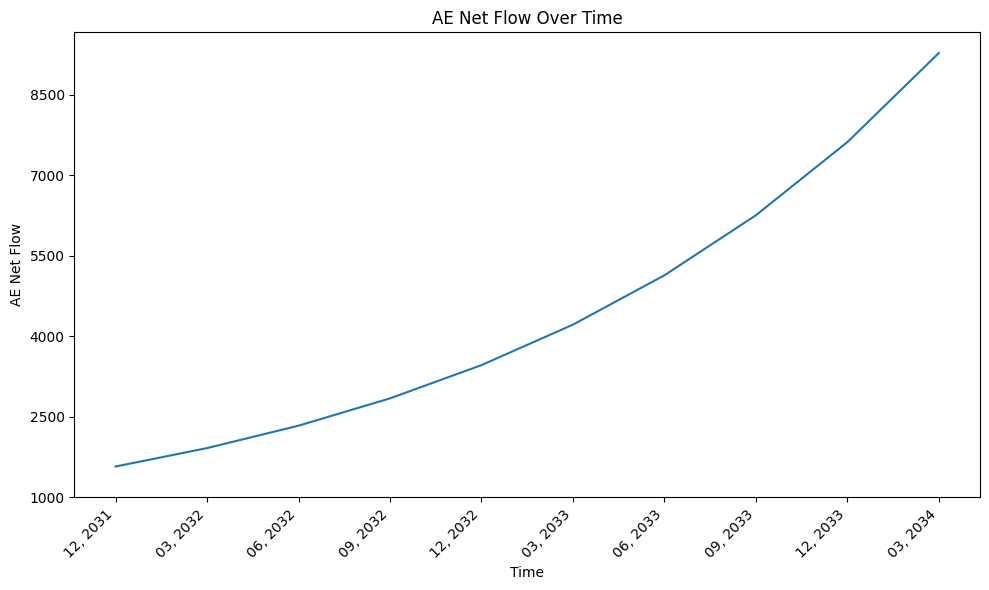

In [620]:
# Convert the 'Time (weeks)' column to datetime format
simulation_results_df['Time'] = pd.to_datetime(simulation_results_df['Time'], format='%d-%m-%Y')

# Calculate the maximum value rounded up to the nearest 500
max_value = math.ceil(simulation_results_df['AE Net Flow'].max() / 500) * 500

# Plotting the time series of AE Net Flow against Time
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.plot(simulation_results_df['Time'], simulation_results_df['AE Net Flow'])

# Giving title to the chart using plt.title
plt.title('AE Net Flow Over Time')

# Set the number of x-axis tick labels to be displayed
num_tick_labels = 10

# Choose indices for tick locations
tick_indices = np.linspace(0, len(simulation_results_df) - 1, num=num_tick_labels, dtype=int)

# Use tick_indices to set tick positions and labels
plt.xticks(simulation_results_df['Time'][tick_indices], simulation_results_df['Time'][tick_indices].dt.strftime('%m, %Y'), rotation=45, ha='right')

# Setting y-axis intervals to 500 starting from the first point of the graph
plt.yticks(np.arange(1000, max_value + 1, 1500))

# Providing x and y label to the chart
plt.xlabel('Time')
plt.ylabel('AE Net Flow')

# Display the plot
plt.tight_layout()
plt.show()

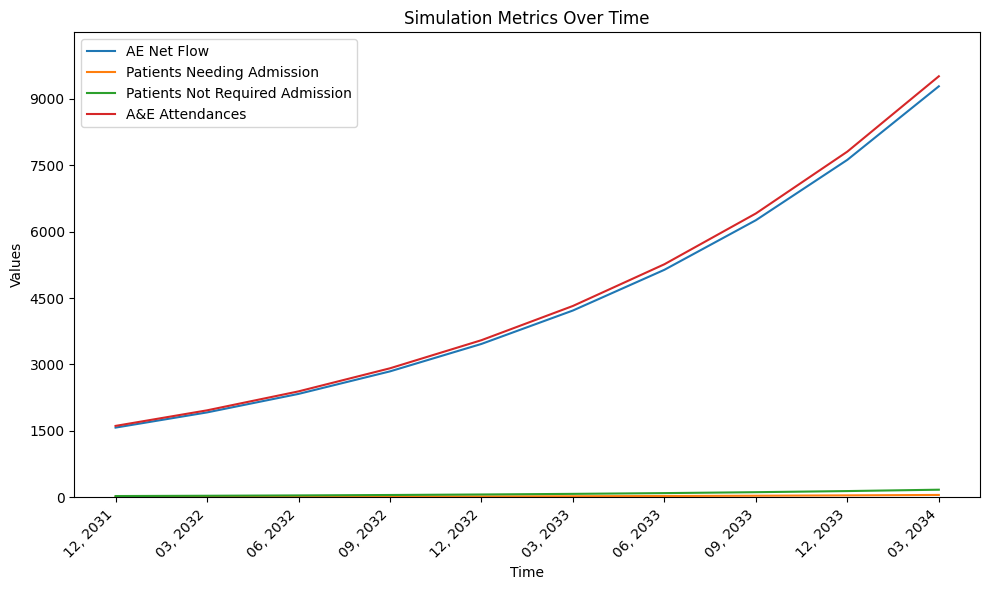

In [621]:

simulation_results_df = pd.read_csv('simulation_results.csv')

simulation_results_df['Time'] = pd.to_datetime(simulation_results_df['Time'], format='%d-%m-%Y')


max_value = math.ceil(simulation_results_df[['AE Net Flow', 'Patients Needing Admission', 'Patients Not Required Admission', 'A&E Attendances']].max().max() / 500) * 500


plt.figure(figsize=(10, 6))

# AE stockflow plotting
plt.plot(simulation_results_df['Time'], simulation_results_df['AE Net Flow'], label='AE Net Flow')

# Patients needing admisison plotting
plt.plot(simulation_results_df['Time'], simulation_results_df['Patients Needing Admission'], label='Patients Needing Admission')

#  Patients Not Required Admission
plt.plot(simulation_results_df['Time'], simulation_results_df['Patients Not Required Admission'], label='Patients Not Required Admission')

#  A&E Attendances
plt.plot(simulation_results_df['Time'], simulation_results_df["A&E Attendances"], label='A&E Attendances')


plt.title('Simulation Metrics Over Time')

num_tick_labels = 10


tick_indices = np.linspace(0, len(simulation_results_df) - 1, num=num_tick_labels, dtype=int)


plt.xticks(simulation_results_df['Time'][tick_indices], simulation_results_df['Time'][tick_indices].dt.strftime('%m, %Y'), rotation=45, ha='right')


plt.ylim(0, max_value + 500)
plt.yticks(np.arange(0, max_value + 200, 1500))


plt.xlabel('Time')
plt.ylabel('Values')


plt.legend()

plt.tight_layout()
plt.show()

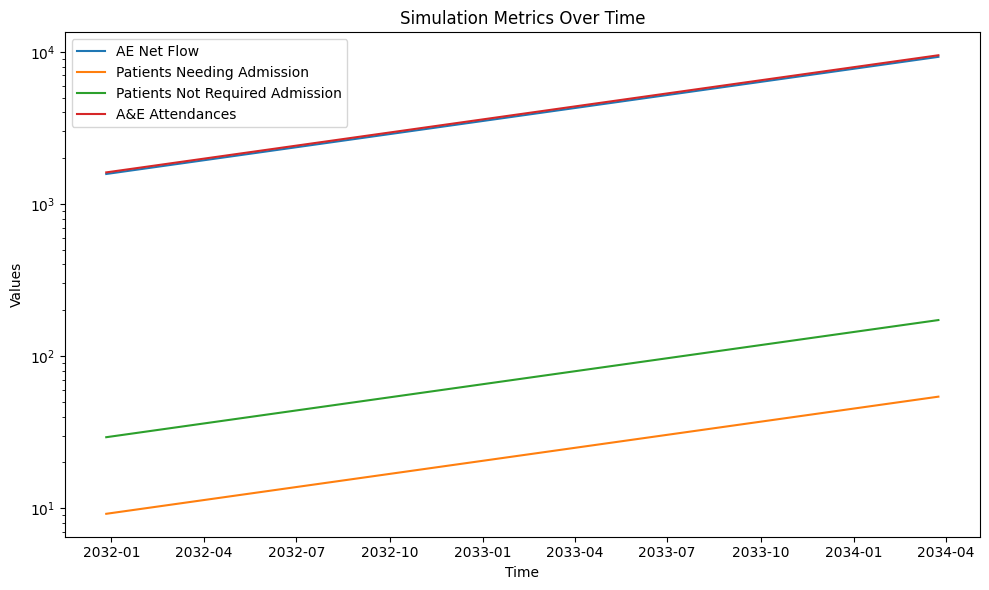

In [622]:
import matplotlib.pyplot as plt
import numpy as np

simulation_results_df = pd.read_csv('simulation_results.csv')

simulation_results_df['Time'] = pd.to_datetime(simulation_results_df['Time'], format='%d-%m-%Y')

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(simulation_results_df['Time'], simulation_results_df['AE Net Flow'], label='AE Net Flow')
plt.plot(simulation_results_df['Time'], simulation_results_df['Patients Needing Admission'], label='Patients Needing Admission')
plt.plot(simulation_results_df['Time'], simulation_results_df['Patients Not Required Admission'], label='Patients Not Required Admission')
plt.plot(simulation_results_df['Time'], simulation_results_df["A&E Attendances"], label='A&E Attendances')

# Set y-axis to log scale
plt.yscale('log')

# Other plot settings
plt.title('Simulation Metrics Over Time')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.tight_layout()

plt.show()

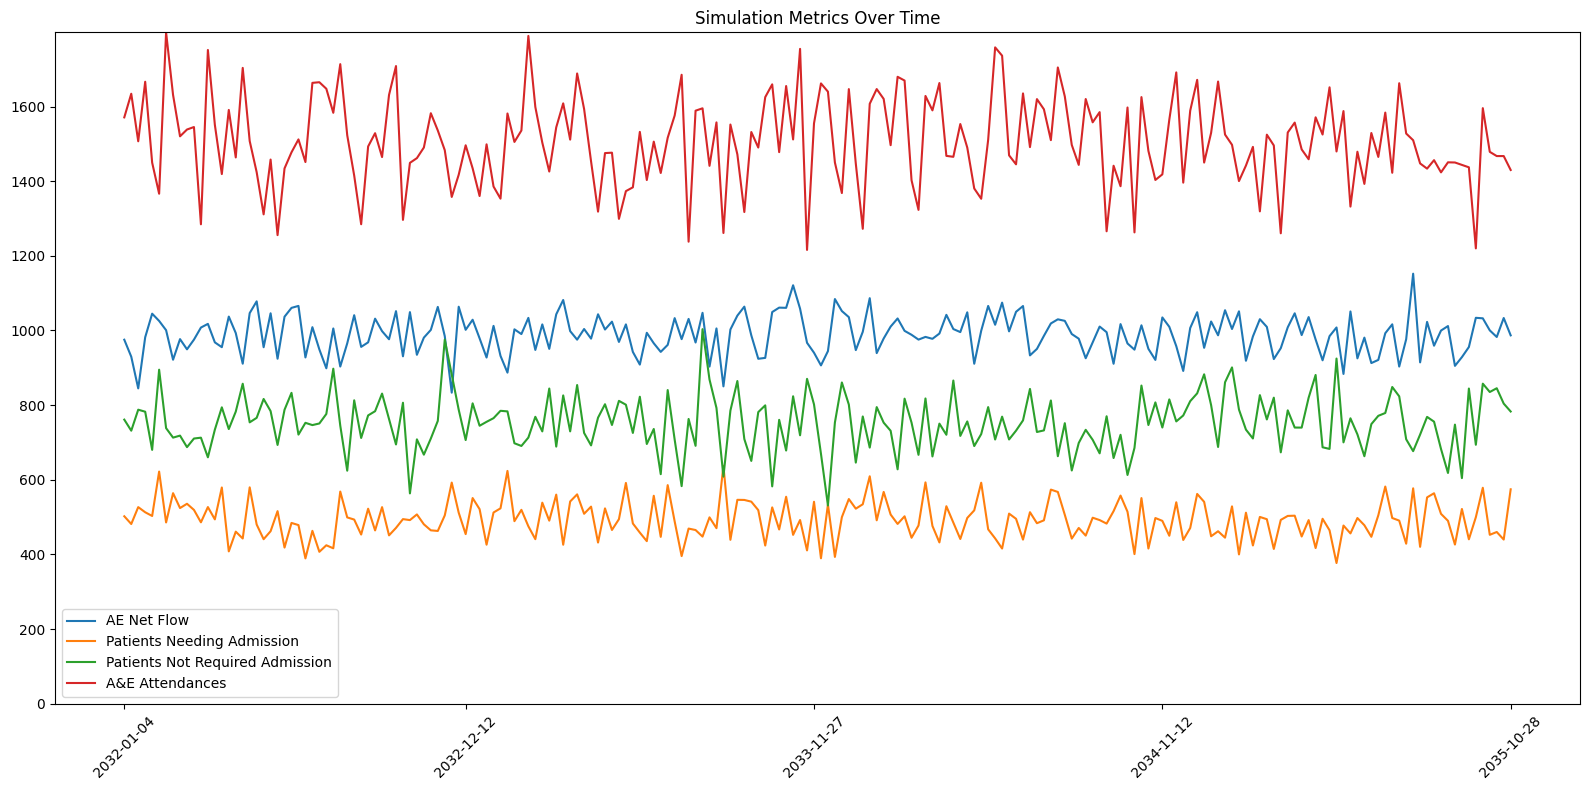

In [623]:
import pandas as pd
import matplotlib.pyplot as plt


simulation_results_df = pd.DataFrame({'Time': pd.date_range('2032-01-01', periods=200, freq='W'),
                                      'AE Net Flow': np.random.randn(200)*50 + 1000,
                                      'Patients Needing Admission': np.random.randn(200)*50 + 500,
                                      'Patients Not Required Admission': np.random.randn(200)*75 + 750,
                                      'A&E Attendances': np.random.randn(200)*125 + 1500})


plt.figure(figsize=(16,8))

plt.plot(simulation_results_df['Time'], simulation_results_df['AE Net Flow'], label='AE Net Flow')
plt.plot(simulation_results_df['Time'], simulation_results_df['Patients Needing Admission'], label='Patients Needing Admission')
plt.plot(simulation_results_df['Time'], simulation_results_df['Patients Not Required Admission'], label='Patients Not Required Admission')
plt.plot(simulation_results_df['Time'], simulation_results_df['A&E Attendances'], label='A&E Attendances')

num_tick_labels = 5
tick_indices = np.linspace(0, len(simulation_results_df)-1, num=num_tick_labels, dtype=int)
plt.xticks(simulation_results_df['Time'][tick_indices], rotation=45)

plt.ylim(0, simulation_results_df[['AE Net Flow', 'Patients Needing Admission', 'Patients Not Required Admission', 'A&E Attendances']].max().max())

plt.legend()
plt.xlabel('')
plt.ylabel('')
plt.title('Simulation Metrics Over Time')

plt.tight_layout()
plt.show()

store and plot non elective waiting admissions

In [624]:

SystemDynamic_NHS.run_non_elective_simulation()
non_elective_simulation_df = SystemDynamic_NHS.get_non_elective_simulation_results_dataframe()
pd.set_option('display.float_format', '{:.6f}'.format)



non_elective_simulation_df.to_csv('non_elective_simulation_results.csv', index=False)
print("Non-Elective Simulation results saved to 'non_elective_simulation_results.csv'")
import matplotlib.pyplot as plt
print(non_elective_simulation_df['Patients Needing Admission'].head(10))
print(non_elective_simulation_df['Patients Needing Admission'].describe())



Rolling average LoS: 0.025135943009355503
Generated normal value: 0.20946012858891155
Non-elective LoS in weeks (calculated): 0.02992287551270165
Rolling average LoS: 0.025135943009355503
Generated normal value: 0.10908233378957172
Non-elective LoS in weeks (calculated): 0.015583190541367389
Rolling average LoS: 0.025135943009355503
Generated normal value: -0.05487840627469149
Non-elective LoS in weeks (calculated): -0.007839772324955927
Rolling average LoS: 0.025135943009355503
Generated normal value: 0.0841118667273999
Non-elective LoS in weeks (calculated): 0.012015980961057129
Rolling average LoS: 0.025135943009355503
Generated normal value: -0.04175642263251154
Non-elective LoS in weeks (calculated): -0.005965203233215934
Rolling average LoS: 0.025135943009355503
Generated normal value: -0.4161922687806393
Non-elective LoS in weeks (calculated): -0.059456038397234186
Rolling average LoS: 0.025135943009355503
Generated normal value: 0.1394568031553214
Non-elective LoS in weeks (cal

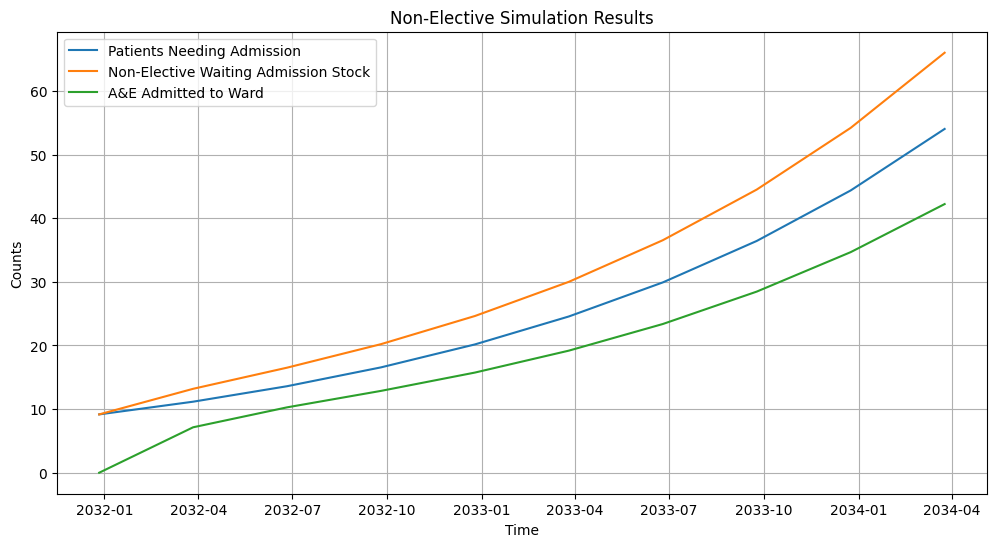

In [625]:

plt.figure(figsize=(12, 6))
plt.plot(non_elective_simulation_df['Time'], non_elective_simulation_df['Patients Needing Admission'], label='Patients Needing Admission')
plt.plot(non_elective_simulation_df['Time'], non_elective_simulation_df['Non-Elective Waiting Admission Stock'], label='Non-Elective Waiting Admission Stock')
plt.plot(non_elective_simulation_df['Time'], non_elective_simulation_df['A&E Admitted to Ward'], label='A&E Admitted to Ward')
plt.legend()
plt.title("Non-Elective Simulation Results")
plt.xlabel("Time")
plt.ylabel("Counts")
plt.grid(True)
plt.show()

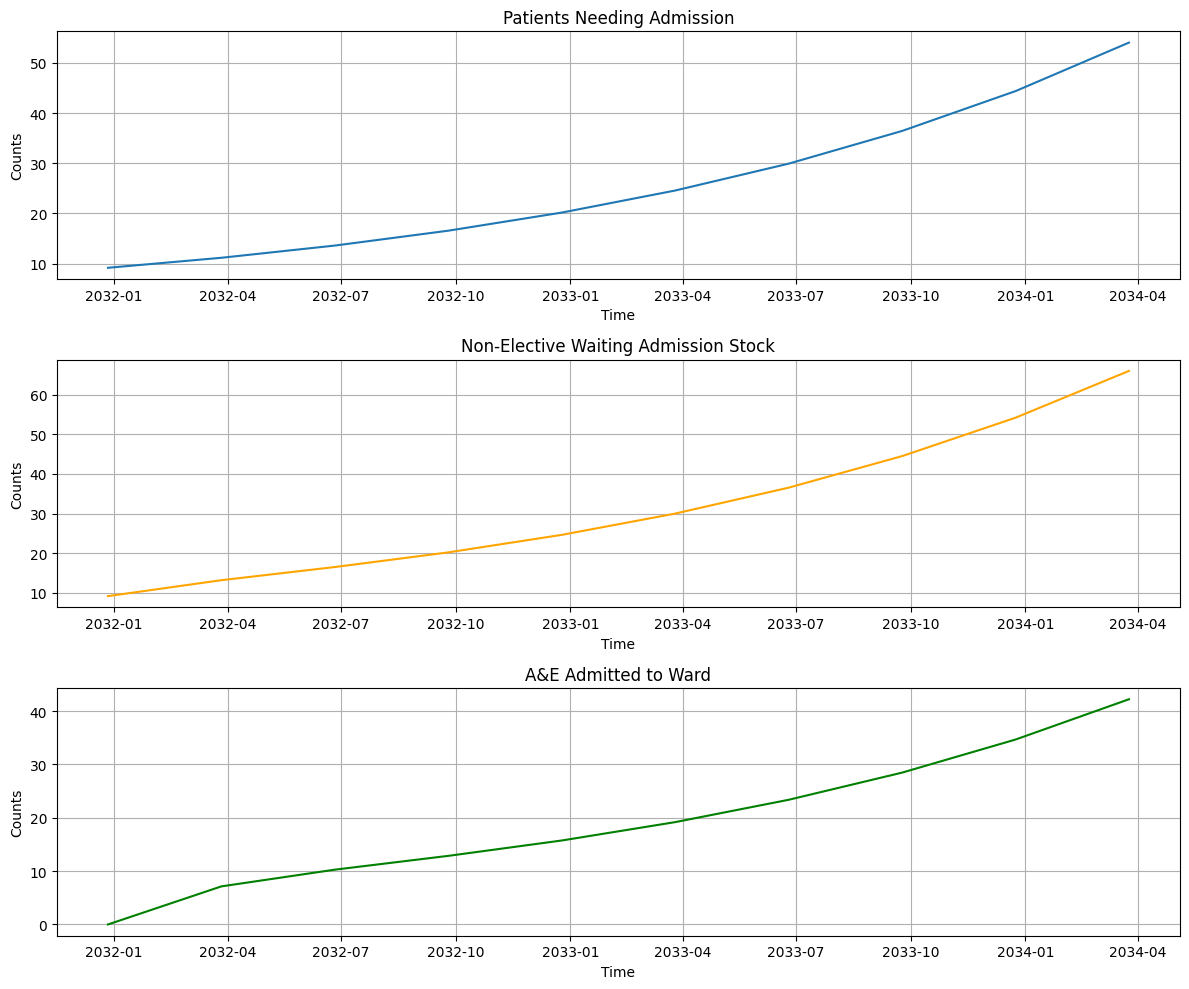

In [626]:
fig, axs = plt.subplots(3, 1, figsize=(12, 10))

axs[0].plot(non_elective_simulation_df['Time'], non_elective_simulation_df['Patients Needing Admission'], label='Patients Needing Admission')
axs[0].set_title("Patients Needing Admission")
axs[0].grid(True)

axs[1].plot(non_elective_simulation_df['Time'], non_elective_simulation_df['Non-Elective Waiting Admission Stock'], label='Non-Elective Waiting Admission Stock', color='orange')
axs[1].set_title("Non-Elective Waiting Admission Stock")
axs[1].grid(True)

axs[2].plot(non_elective_simulation_df['Time'], non_elective_simulation_df['A&E Admitted to Ward'], label='A&E Admitted to Ward', color='green')
axs[2].set_title("A&E Admitted to Ward")
axs[2].grid(True)

for ax in axs:
    ax.set_xlabel("Time")
    ax.set_ylabel("Counts")

plt.tight_layout()
plt.show()


In [627]:

times, occupied_beds, inflows, outflows = SystemDynamic_NHS.beds_occupied_by_non_electives()


beds_occupied_df = pd.DataFrame({'Time': times,'Beds Occupied': occupied_beds,'Inflows': inflows,'Outflows': outflows})

print(beds_occupied_df.head())


Rolling average LoS: 0.025135943009355503
Generated normal value: -0.16392380175005983
Non-elective LoS in weeks (calculated): -0.02341768596429426
Rolling average LoS: 0.025135943009355503
Generated normal value: -0.13402759889327898
Non-elective LoS in weeks (calculated): -0.019146799841896996
Rolling average LoS: 0.025135943009355503
Generated normal value: 0.23748059200366134
Non-elective LoS in weeks (calculated): 0.033925798857665904
Rolling average LoS: 0.025135943009355503
Generated normal value: 0.06071063207777709
Non-elective LoS in weeks (calculated): 0.008672947439682442
Rolling average LoS: 0.025135943009355503
Generated normal value: -0.11616083147489137
Non-elective LoS in weeks (calculated): -0.016594404496413053
Rolling average LoS: 0.025135943009355503
Generated normal value: 0.06247015159294068
Non-elective LoS in weeks (calculated): 0.008924307370420097
Rolling average LoS: 0.025135943009355503
Generated normal value: -0.446456410347495
Non-elective LoS in weeks (c

Rolling average LoS: 0.025135943009355503
Generated normal value: 0.2762160924425433
Non-elective LoS in weeks (calculated): 0.03945944177750619
Rolling average LoS: 0.025135943009355503
Generated normal value: -0.07506986409990696
Non-elective LoS in weeks (calculated): -0.010724266299986709
Rolling average LoS: 0.025135943009355503
Generated normal value: 0.309464900087839
Non-elective LoS in weeks (calculated): 0.04420927144111986
Rolling average LoS: 0.025135943009355503
Generated normal value: -0.35469298780872843
Non-elective LoS in weeks (calculated): -0.05067042682981835
Rolling average LoS: 0.025135943009355503
Generated normal value: -0.17454590016352753
Non-elective LoS in weeks (calculated): -0.024935128594789645
Rolling average LoS: 0.025135943009355503
Generated normal value: -0.12104120416195277
Non-elective LoS in weeks (calculated): -0.017291600594564683
Rolling average LoS: 0.025135943009355503
Generated normal value: 0.566028744382162
Non-elective LoS in weeks (calcu

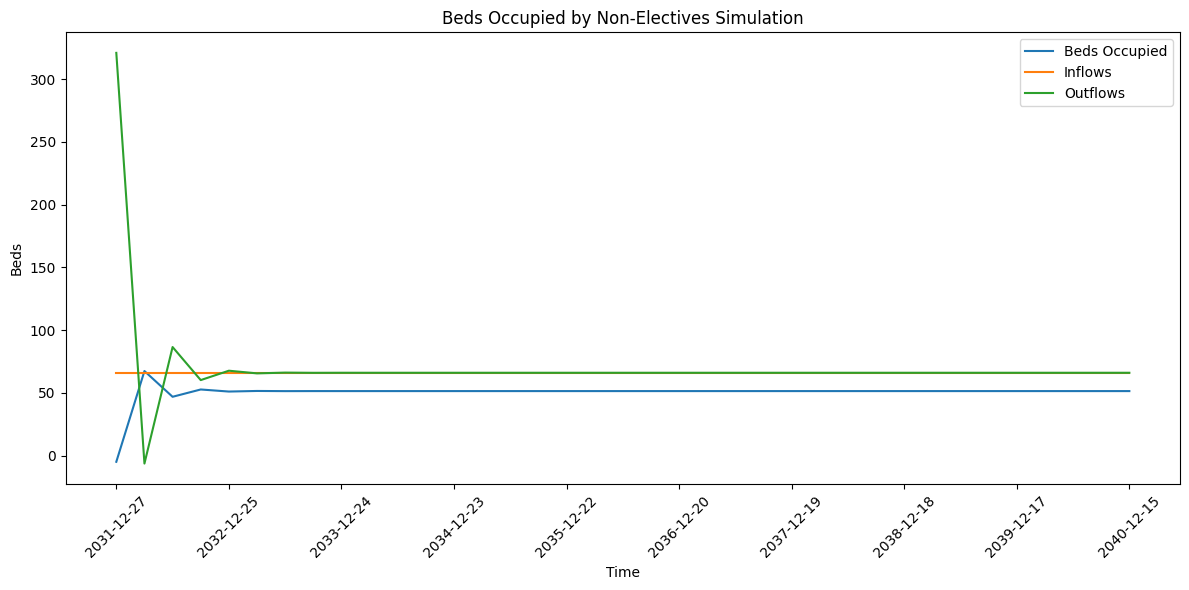

In [628]:

times, occupied_beds, inflows, outflows = SystemDynamic_NHS.beds_occupied_by_non_electives()


beds_df = pd.DataFrame({
    'Time': times,
    'Beds Occupied': occupied_beds,
    'Inflows': inflows,
    'Outflows': outflows
})


beds_df['Time'] = pd.to_datetime(beds_df['Time'])


plt.figure(figsize=(12,6))

plt.plot(beds_df['Time'], beds_df['Beds Occupied'], label='Beds Occupied')
plt.plot(beds_df['Time'], beds_df['Inflows'], label='Inflows')
plt.plot(beds_df['Time'], beds_df['Outflows'], label='Outflows')

plt.title('Beds Occupied by Non-Electives Simulation')
plt.xlabel('Time')
plt.ylabel('Beds')
plt.legend()


num_ticks = 10
tick_indices = np.linspace(0, len(beds_df)-1, num=num_ticks, dtype=int)
plt.xticks(beds_df['Time'][tick_indices], rotation=45)

plt.tight_layout()
plt.show()

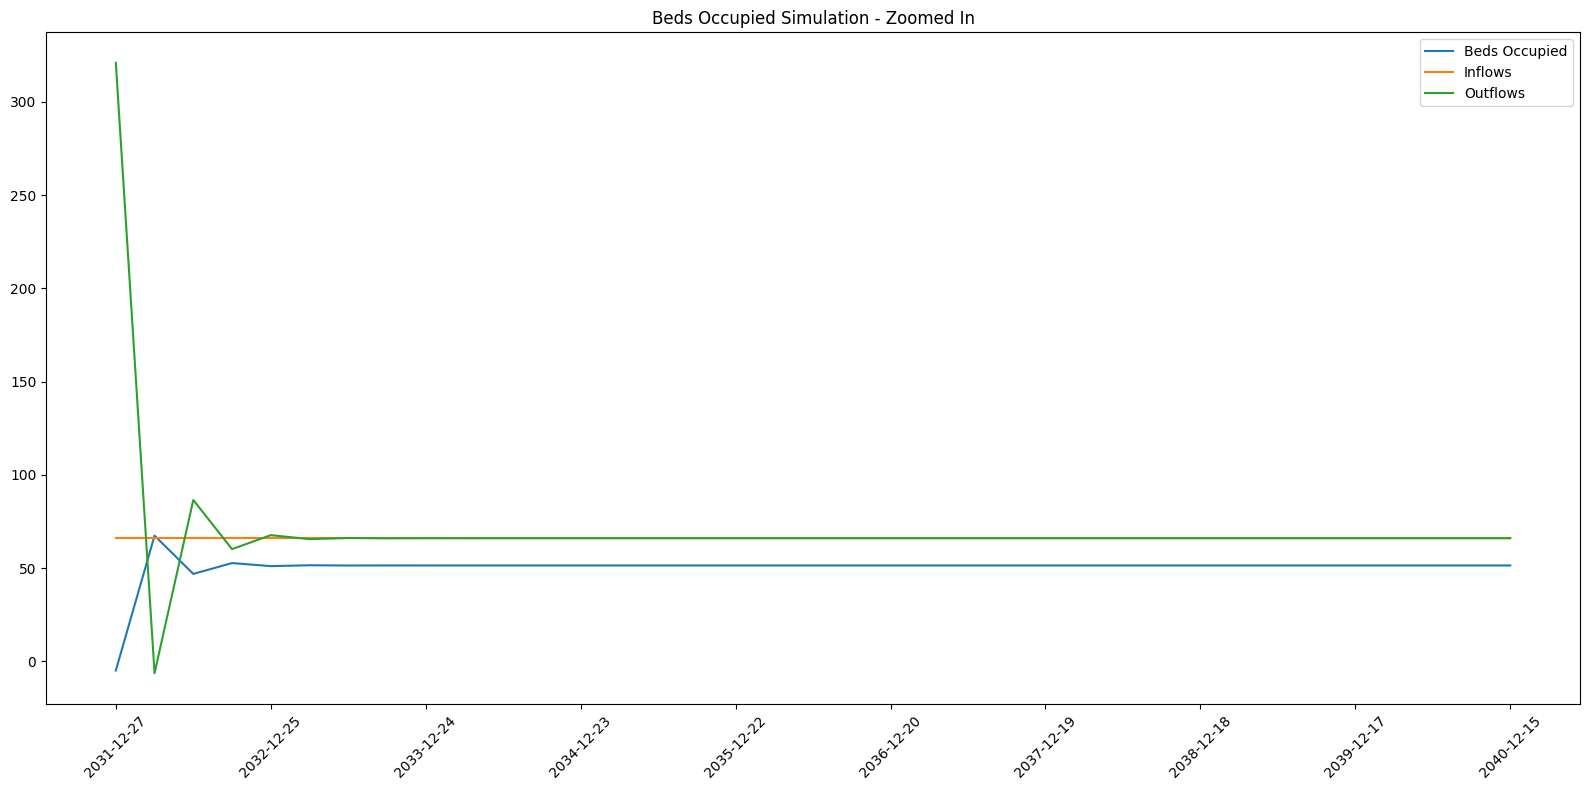

In [629]:
import matplotlib.pyplot as plt
import numpy as np

# Plot zoomed in view
plt.figure(figsize=(16,8))

plt.plot(beds_df['Time'], beds_df['Beds Occupied'], label='Beds Occupied')
plt.plot(beds_df['Time'], beds_df['Inflows'], label='Inflows')
plt.plot(beds_df['Time'], beds_df['Outflows'], label='Outflows')

# Zoom in x-axis
num_ticks = 10
tick_indices = np.linspace(0, len(beds_df)-1, num=num_ticks, dtype=int)
plt.xticks(beds_df['Time'][tick_indices], rotation=45)

plt.legend()
plt.title('Beds Occupied Simulation - Zoomed In')
plt.tight_layout()
plt.show()



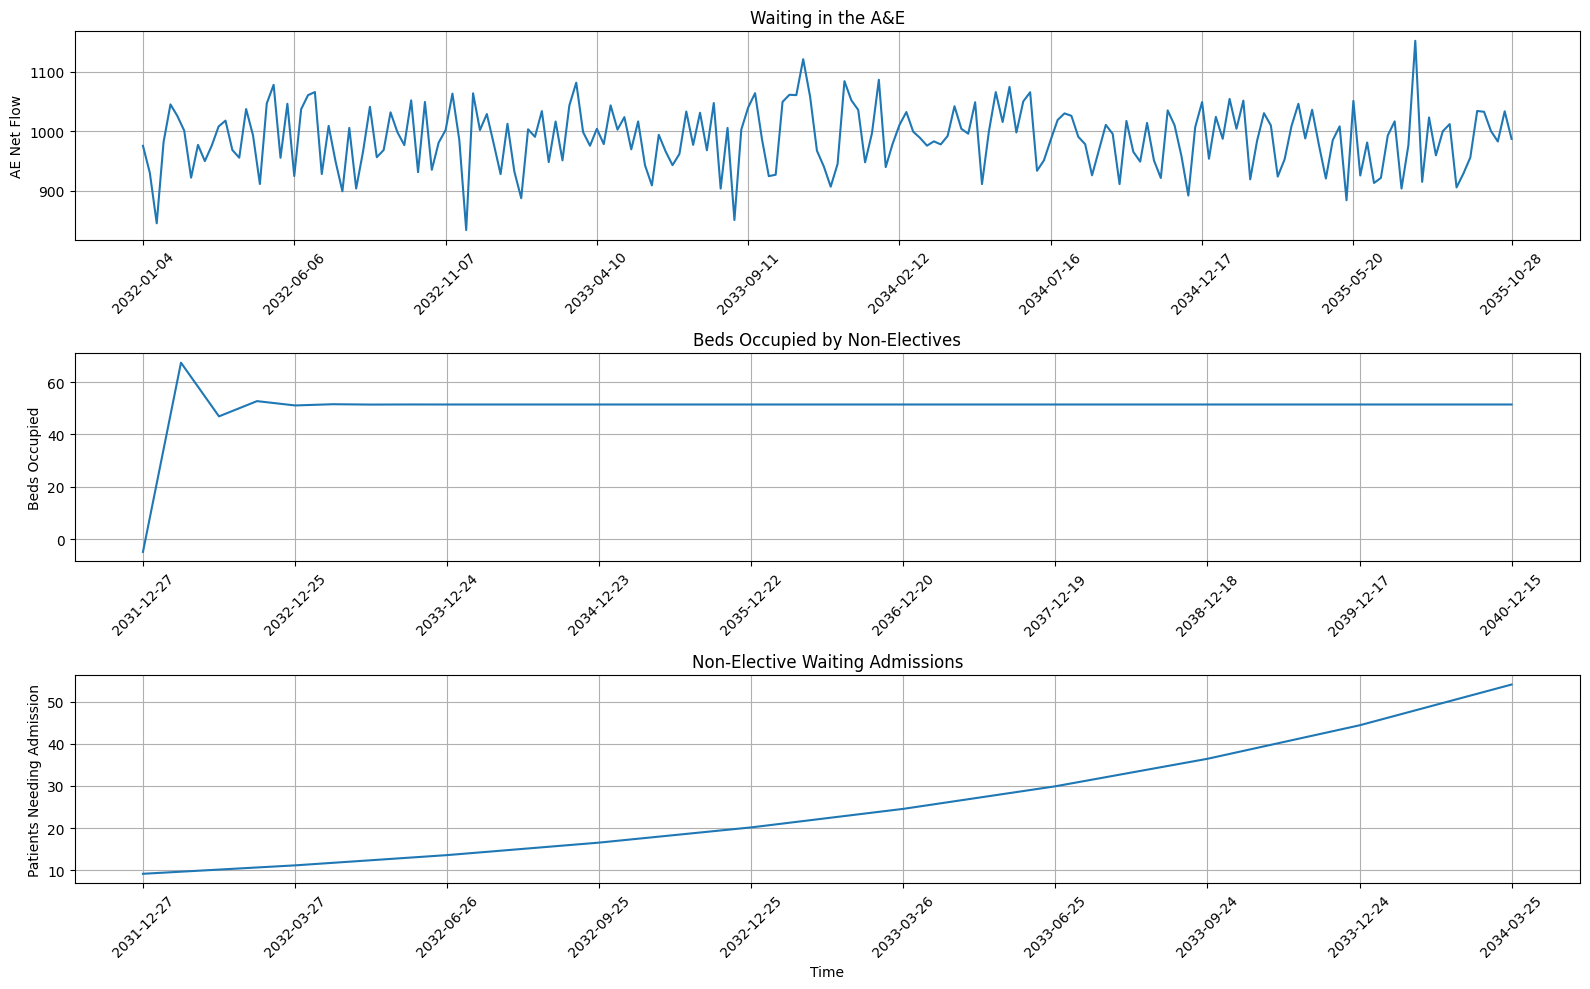

In [630]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming the dataframes are named 'simulation_results_df', 'non_elective_simulation_df', and 'beds_df'

# Set up the figure and axes
fig, axs = plt.subplots(3, 1, figsize=(16, 10))

# Plotting for "waiting in the A&E"
axs[0].plot(simulation_results_df['Time'], simulation_results_df['AE Net Flow'], label='AE Net Flow')
axs[0].set_title('Waiting in the A&E')
axs[0].set_ylabel('AE Net Flow')
num_ticks = 10
tick_indices = np.linspace(0, len(simulation_results_df)-1, num=num_ticks, dtype=int)
axs[0].set_xticks(simulation_results_df['Time'][tick_indices])
axs[0].tick_params(axis='x', rotation=45)
axs[0].grid(True)

# Plotting for "beds occupied by non-electives"
axs[1].plot(beds_df['Time'], beds_df['Beds Occupied'], label='Beds Occupied')
axs[1].set_title('Beds Occupied by Non-Electives')
axs[1].set_ylabel('Beds Occupied')
num_ticks = 10
tick_indices = np.linspace(0, len(beds_df)-1, num=num_ticks, dtype=int)
axs[1].set_xticks(beds_df['Time'][tick_indices])
axs[1].tick_params(axis='x', rotation=45)
axs[1].grid(True)

# Plotting for "non-elective waiting admissions"
axs[2].plot(non_elective_simulation_df['Time'], non_elective_simulation_df['Patients Needing Admission'], label='Patients Needing Admission')
axs[2].set_title('Non-Elective Waiting Admissions')
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Patients Needing Admission')
num_ticks = 10
tick_indices = np.linspace(0, len(non_elective_simulation_df)-1, num=num_ticks, dtype=int)
axs[2].set_xticks(non_elective_simulation_df['Time'][tick_indices])
axs[2].tick_params(axis='x', rotation=45)
axs[2].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()


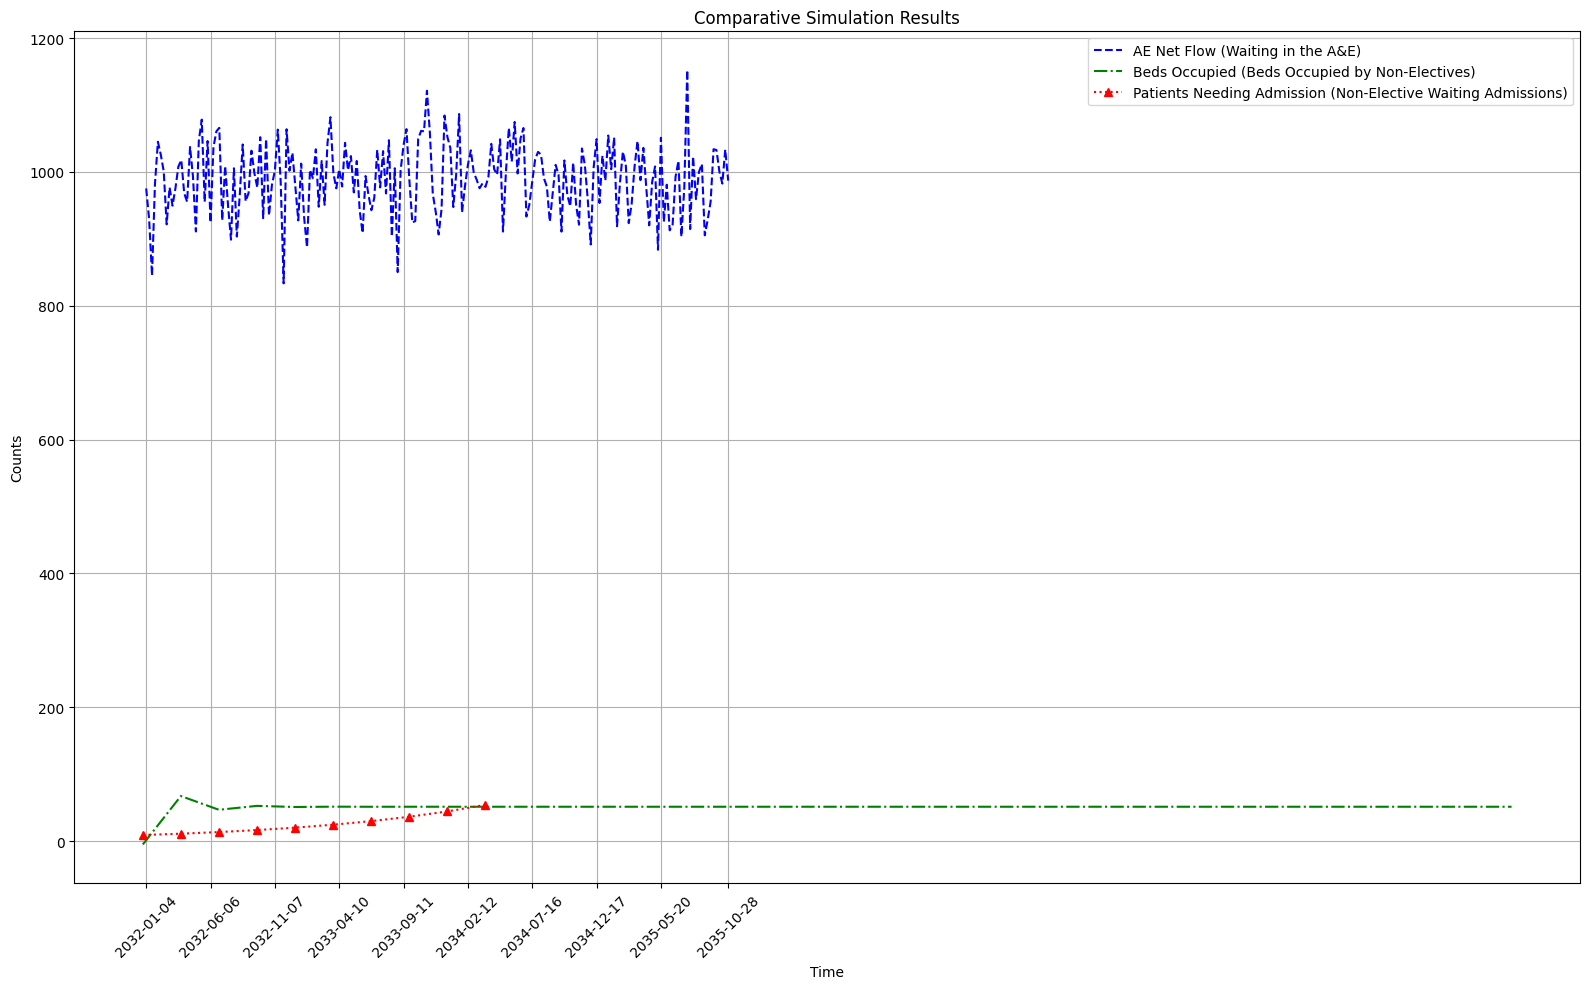

In [631]:
import matplotlib.pyplot as plt

# Set up the figure
plt.figure(figsize=(16, 10))

# Plotting for "waiting in the A&E"
plt.plot(simulation_results_df['Time'], simulation_results_df['AE Net Flow'], 'b--', label='AE Net Flow (Waiting in the A&E)')

# Plotting for "beds occupied by non-electives"
plt.plot(beds_df['Time'], beds_df['Beds Occupied'], 'g-.', label='Beds Occupied (Beds Occupied by Non-Electives)')

# Plotting for "non-elective waiting admissions"
plt.plot(non_elective_simulation_df['Time'], non_elective_simulation_df['Patients Needing Admission'], 'r:', marker='^', label='Patients Needing Admission (Non-Elective Waiting Admissions)')

# Title and labels
plt.title('Comparative Simulation Results')
plt.xlabel('Time')
plt.ylabel('Counts')

# Format x-axis ticks
num_ticks = 10
tick_indices = np.linspace(0, len(simulation_results_df)-1, num=num_ticks, dtype=int)
plt.xticks(simulation_results_df['Time'][tick_indices], rotation=45)

# Legend
plt.legend()

# Grid
plt.grid(True)

# Adjust layout and show plot
plt.tight_layout()
plt.show()


In [632]:
results_run_non_elective = pd.DataFrame(columns=[
    'Time', 'Patients Needing Admission', 'Non-Elective Waiting Admission Stock', 'A&E Admitted to Ward', 'Beds Available'
])

results_beds_occupied_non_electives = pd.DataFrame(columns=[
    'Time', 'Beds Occupied', 'Inflow', 'Outflow'
])
# Run the non-elective simulation and store results
SystemDynamic_NHS.run_non_elective_simulation()

for i, running_time in enumerate(SystemDynamic_NHS.time_values):
    if start_time_of_simulation <= running_time <= end_date_for_simulation:
        patients_needing_admission_value = SystemDynamic_NHS.needing_admission_values[i]
        waiting_admission_value = SystemDynamic_NHS.waiting_admission_values[i]
        a_e_admitted_ward_value = SystemDynamic_NHS.a_e_admitted_ward_values[i]
        beds_available_value = SystemDynamic_NHS.beds_available_values[i]

        results_run_non_elective.loc[i] = [
            running_time, patients_needing_admission_value, waiting_admission_value, a_e_admitted_ward_value, beds_available_value
        ]

# Run the beds occupied by non-electives simulation and store results
times, occupied_beds, inflows, outflows = SystemDynamic_NHS.beds_occupied_by_non_electives()

for i, t in enumerate(times):
    if start_time_of_simulation <= t <= end_date_for_simulation:
        beds_occupied_value = occupied_beds[i]
        inflow_value = inflows[i]
        outflow_value = outflows[i]

        results_beds_occupied_non_electives.loc[i] = [
            t, beds_occupied_value, inflow_value, outflow_value
        ]
results_run_non_elective.to_csv('results_run_non_elective.csv', index=False)
results_beds_occupied_non_electives.to_csv('results_beds_occupied_non_electives.csv', index=False)

Rolling average LoS: 0.025135943009355503
Generated normal value: 0.051158012384086814
Non-elective LoS in weeks (calculated): 0.007308287483440973
Rolling average LoS: 0.025135943009355503
Generated normal value: -0.09069338179832367
Non-elective LoS in weeks (calculated): -0.012956197399760524
Rolling average LoS: 0.025135943009355503
Generated normal value: 0.17513861471173195
Non-elective LoS in weeks (calculated): 0.02501980210167599
Rolling average LoS: 0.025135943009355503
Generated normal value: -0.21344213387158467
Non-elective LoS in weeks (calculated): -0.03049173341022638
Rolling average LoS: 0.025135943009355503
Generated normal value: 0.28589854226202455
Non-elective LoS in weeks (calculated): 0.04084264889457494
Rolling average LoS: 0.025135943009355503
Generated normal value: -0.0911320326358746
Non-elective LoS in weeks (calculated): -0.013018861805124944
Rolling average LoS: 0.025135943009355503
Generated normal value: 0.04862372133861395
Non-elective LoS in weeks (ca

In [633]:
import pandas as pd

# Generate time values array
time_values = np.arange(len(beds_occupied_values))

# Calculate proportion beds
prop_values = SystemDynamic_NHS.proportion_beds_for_non_electives(beds_occupied_values, historical_bed_capacity_values, 4)

# Create dataframe
results_df = pd.DataFrame({
    'Time': time_values,
    'Beds Occupied': beds_occupied_values,
    'Proportion Beds': prop_values
})

# Save to CSV
results_df.to_csv('results.csv', index=False)

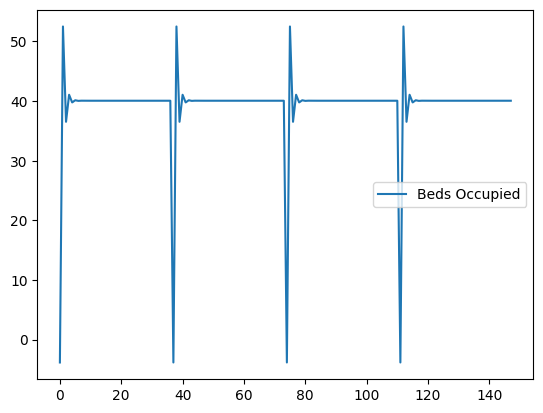

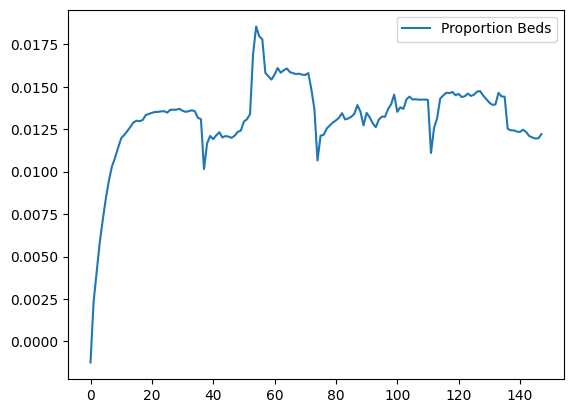

In [634]:
plt.plot(results_df['Time'], results_df['Beds Occupied'], label='Beds Occupied')
plt.legend()
plt.show()
plt.plot(results_df['Time'], results_df['Proportion Beds'], label='Proportion Beds')

plt.legend()
plt.show()